In [1]:
pip install SimpleITK

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# DRAW MATPLOTLIB IN NOTEBOOK #

#%matplotlib inline
#%matplotlib notebook



# LIBRARIES #

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, interpolate # , optimize # other possibility to fit the curves

import SimpleITK

In [4]:
# INPUT PARAMETERS #

m_fns = ['tif1/scan1.tif', 'tif1/scan2.tif', 'tif1/scan3.tif', 'tif1/scan4.tif', 'tif1/scan5.tif']


list0 = [799.7, 599.8, 399.9, 299.9, 199.9, 100.0, 50.4, 24.8] # Dose values

display_strips = False

def fitting_func(x, a, b, c, d):
    return a * (x**3) + b * (x**2) + c*x + d

In [5]:
# CREATION OF THE MEDIAN IMAGE #

arrays = [0 for i in range(len(m_fns))]

def get_med_img(arr):
    """
        Creates a median array from a list of arrays 
        
        :param arr: a list of arrays
        :type arr: list or numpy.ndarray
        :return: the median array
        :rtype: numpy.ndarray
        
        :Example:
        
        >>> import numpy
        >>> a = numpy.array([[7,8,9],[16,17,18]])
        >>> b = numpy.array([[13,14,15],[4,5,6]])
        >>> c = numpy.array([[1,2,3],[10,11,12]])
        >>> print(get_med_img([a, b, c]))
        [[ 7.  8.  9.]
         [10. 11. 12.]]
    """
    l3d = np.array(arr)
    return np.median(l3d, axis=0)

# TIFF images setup
img = SimpleITK.ReadImage(m_fns[0])
sizex = img.GetWidth()
sizey = img.GetHeight()
arrays[0] = SimpleITK.GetArrayFromImage(img)

for i in range(1,len(m_fns)):
    img = SimpleITK.ReadImage(m_fns[i])
    sx = img.GetWidth()
    sy = img.GetHeight()
    assert(sx==sizex and sy==sizey)
    arrays[i] = SimpleITK.GetArrayFromImage(img)

array = get_med_img(arrays)


# replaces every 65535 value in array with 65534 to prevent division by zero:
array[array==65535]=65534
array = array / 65535.0

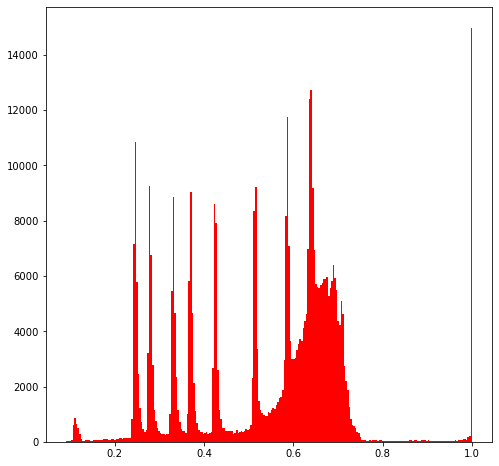

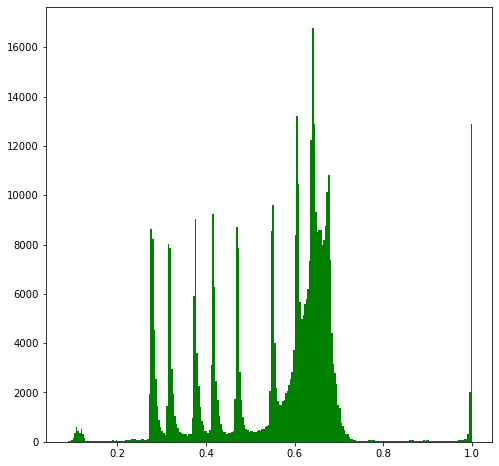

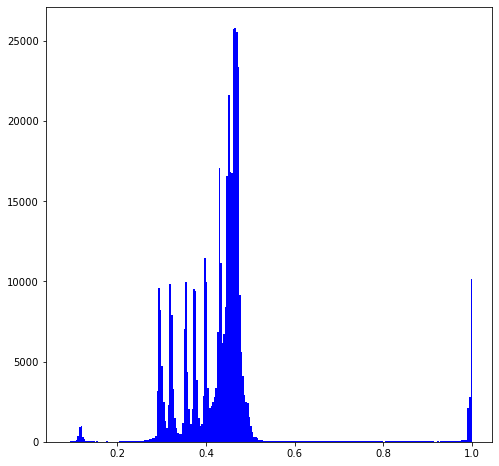

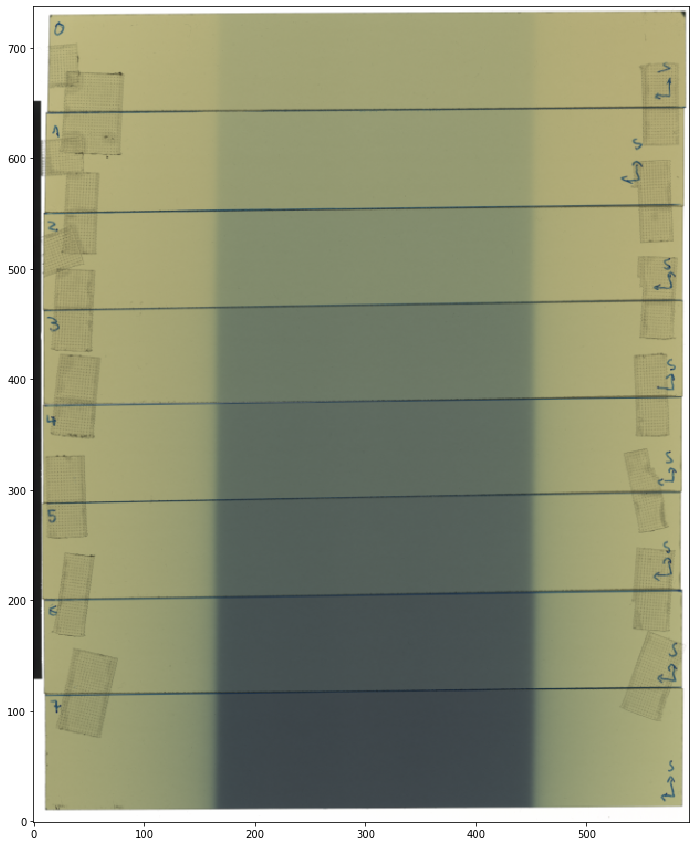

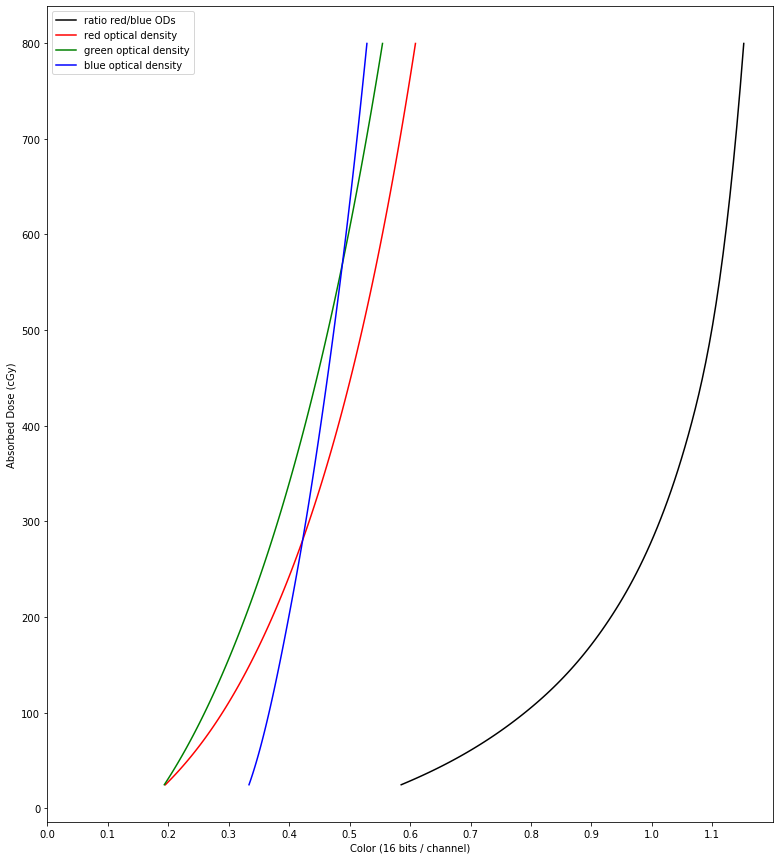

In [6]:
# MATPLOTLIB #
list1 = [0 for i in range(8)] # list of length 8

plt.rcParams['figure.figsize'] = (8, 8)


# Red channel histogram
fig, hR = plt.subplots()
hR.hist(array[:,:,0].flat, color='red', bins=256)

# Green channel histogram
fig, hG = plt.subplots()
hG.hist(array[:,:,1].flat, color='green', bins=256)

# Blue channel histogram
fig, hB = plt.subplots()
hB.hist(array[:,:,2].flat, color='blue', bins=256)

plt.rcParams['figure.figsize'] = (13, 15)

# displays the image
fig, ax1 = plt.subplots()
im1 = ax1.imshow(array, origin='lower')

divider1 = make_axes_locatable(ax1)

thirdx = sizex//3 # third of the length of a strip

# splits the image in 8 strips
for i in range(7, -1, -1):
    centy = (2*i+1)*(sizey//8)//2 # mid-height of the current strip
    
    if display_strips:
        fig, ax2 = plt.subplots()
        ax2.imshow(array[centy-10 : centy+10, thirdx : 2*thirdx], origin='lower') # displays the current strip
        ax2.set_title(list0[i])
    
    zoi = array[centy-10 : centy+10, thirdx : 2*thirdx] # zone of interest
    list1[i] = (np.mean(zoi[:,:,0]), np.mean(zoi[:,:,1]), np.mean(zoi[:,:,2]))

list1 = np.array(list1) # contains the median color of each strip

# setups the plot
fig, ax3 = plt.subplots()
dor = -np.log10(list1[:, 0]) # red curve
dog = -np.log10(list1[:, 1]) # green curve
dob = -np.log10(list1[:, 2]) # blue curve
rsb = dor / dob # black curve

legend_list = [(rsb, 'k', 'ratio red/blue ODs'), (dor, 'r', 'red optical density'), (dog, 'g', 'green optical density'), (dob, 'b', 'blue optical density')]

for e in legend_list: # fitting the curves
    # calculate natural cubic spline polynomials
    x = e[0]

    cs = interpolate.CubicSpline(x[::-1], list0[::-1])
    
    xb = np.linspace(min(x), max(x), num=100)
    
    #ax3.plot(x, list0, e[1]+'*')
    ax3.plot(xb, cs(xb), e[1], label=e[2])

# /!\ stocker les valeurs x et cs(x) en JSON #

ax3.set_xlim(left=0)
xliml, xlimr = ax3.get_xlim()
ax3.set_xticks(np.arange(xliml, xlimr, 0.1))
ax3.legend()
ax3.set_ylabel('Absorbed Dose (cGy)')
ax3.set_xlabel('Color (16 bits / channel)')
print('') # To get rid of "Text(0.5, 0, 'Color (16 bits / channel)')"

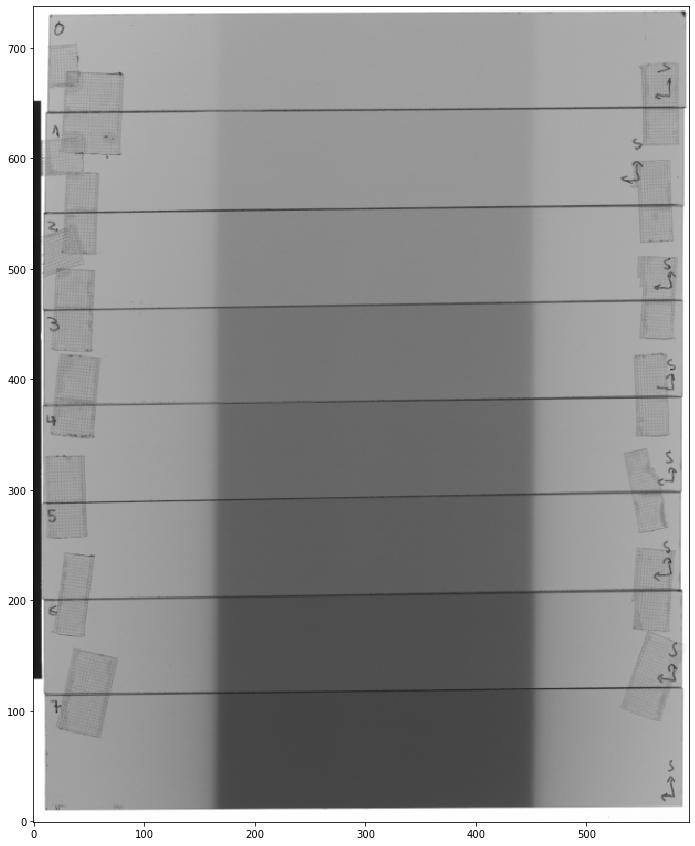

In [7]:
# GREYSCALE IMAGE CREATION #

#luma_coeff = [0.299, 0.587, 0.114]
luma_coeff = [0.2126, 0.7152, 0.0722]

def rgb2grey(rgb):
    """
        Creates a luma transformation of an rgb array
        
        :param rgb: a list of arrays
        :type rgb: numpy.ndarray
        :return: the grey array
        :rtype: numpy.ndarray
        
        :Example:
        
        >>> import numpy
        >>> a = numpy.array([1,2,3])
        >>> print(rgb2grey(a))
        [1.8596 1.8596 1.8596]
    """
    luma = rgb[0] * luma_coeff[0] + rgb[1] * luma_coeff[1] + rgb[2] * luma_coeff[2]
    formula = [luma, luma, luma]
    return np.array(formula)

grey_array = [] # not optimized
for i in range(len(array)):
    inter = []
    for j in range(len(array[i])):
        inter.append(rgb2grey(array[i][j]))
    grey_array.append(np.array(inter))

grey_array = np.array(grey_array)

fig, axz = plt.subplots()
axz.imshow(grey_array, origin='lower')
print('')

In [8]:
# EXPORTING GREYSCALE IMAGE #

from PIL import Image
import os

# /!\ utiliser SimpleITK #

nameTiff = "grey_test.tiff"
#grey_array= grey_array.astype(np.float32)#si tu veux l'enregistrer dans un type qui n'est pas le même que celui de base
arrayb = grey_array.tobytes()
im = Image.frombytes('F', (512,512), arrayb, decoder_name='raw')
im.save(os.path.join('',nameTiff), "TIFF")